In [1]:
import pandas as pd

In [2]:
year = 2017
country = "France"
rnd = "first_round"
location_level = "department"

RATE_THRESHOLD = 0.02

In [3]:
df_location = pd.read_csv(f"data_output/{country}/{year}_first_round_location.csv.gz", compression="gzip") #_{rnd}
df_location.head()

,polling_id,department_id,department,circunscription_id,circunscription,commune_id,commune,polling_place,electors,abstentions
0,Ain-4ème circonscription-L'Abergement-Clémenci...,1,Ain,4,4ème circonscription,1,L'Abergement-Clémenciat,M,598,92
1,Ain-5ème circonscription-L'Abergement-de-Varey-M,1,Ain,5,5ème circonscription,2,L'Abergement-de-Varey,M,209,25
2,Ain-5ème circonscription-Ambérieu-en-Bugey-M,1,Ain,5,5ème circonscription,4,Ambérieu-en-Bugey,M,1116,233
3,Ain-5ème circonscription-Ambérieu-en-Bugey-M,1,Ain,5,5ème circonscription,4,Ambérieu-en-Bugey,M,1128,256
4,Ain-5ème circonscription-Ambérieu-en-Bugey-M,1,Ain,5,5ème circonscription,4,Ambérieu-en-Bugey,M,1116,227


In [4]:
df_dv = pd.read_csv(f"data_output/{country}/{year}_divisiveness_{location_level}.csv.gz", compression="gzip") #_{rnd}
df_dv = pd.merge(df_dv, df_location[["department_id", "department"]], on="department")
df_dv.head()

,department,candidate,value,department_id
0,Ain,Benoît HAMON,0.017908,1
1,Ain,Benoît HAMON,0.017908,1
2,Ain,Benoît HAMON,0.017908,1
3,Ain,Benoît HAMON,0.017908,1
4,Ain,Benoît HAMON,0.017908,1


In [10]:
df_poverty = pd.read_excel("data_external/France/poverty_2017.xlsx", sheet_name="Figure 3", header=2).dropna()
df_poverty = df_poverty.rename(columns={"Code": "department_id", "Taux de pauvreté": "poverty"})
df_poverty["poverty"] = df_poverty["poverty"] / 100
# df_poverty["department_id"] = df_poverty["department_id"].astype(int)
df_poverty.head()

,department_id,Département,poverty
0,74,Haute-Savoie,0.091
1,85,Vendée,0.093
2,78,Yvelines,0.094
3,73,Savoie,0.098
4,44,Loire-Atlantique,0.101


In [42]:
!pip install geopy --user
import geopy.distance


[notice] A new release of pip available: 22.2.1 -> 22.2.2
[notice] To update, run: python.exe -m pip install --upgrade pip


     -------------------------------------- 118.9/118.9 kB 2.3 MB/s eta 0:00:00


In [12]:
df = pd.merge(
    df_location.groupby("department_id").agg({"electors": "sum", "abstentions": "sum"}).reset_index(),
    df_dv.groupby("department_id").agg({"value": "mean"}).reset_index(),
    on="department_id"
)
df["department_id"] = df["department_id"].str.zfill(2)
df = pd.merge(df, df_poverty, on="department_id")

print(df.shape)
df["turnout_rate"] = df["electors"] / (df["electors"] + df["abstentions"])
df.head()

(96, 6)


,department_id,electors,abstentions,value,Département,poverty,turnout_rate
0,01,415886,81507,0.041324,Ain,0.105,0.836132
1,10,203847,38951,0.054249,Aube,0.163,0.839574
2,11,272695,52553,0.059579,Aude,0.208,0.838422
3,12,218276,36378,0.045127,Aveyron,0.139,0.857147
4,13,1372394,300146,0.046408,Bouches-du-Rhône,0.182,0.820545


In [13]:
df[["turnout_rate", "value", "department_id", "poverty"]].sort_values("department_id")\
    .to_csv(f"data_regressions/Turnout_{country}_{year}.csv", index=False)

In [14]:
df_dv_a = pd.read_csv(f"data_output/{country}/2017_divisiveness_{location_level}.csv.gz", compression="gzip") #_{rnd}
df_dv_a = pd.merge(df_dv_a, df_location[["department_id", "department"]], on="department")


df_dv_b = pd.read_csv(f"data_output/{country}/2022_divisiveness_{location_level}.csv.gz", compression="gzip") #_{rnd}
df_dv_b = pd.merge(df_dv_b, df_location[["department_id", "department"]], on="department")


In [20]:
df_dv_a

,department,candidate,value,department_id
0,Ain,Benoît HAMON,0.017908,1
1,Ain,Benoît HAMON,0.017908,1
2,Ain,Benoît HAMON,0.017908,1
3,Ain,Benoît HAMON,0.017908,1
4,Ain,Benoît HAMON,0.017908,1
...,...,...,...,...
415447,Yvelines,Nicolas DUPONT-AIGNAN,0.014580,78
415448,Yvelines,Nicolas DUPONT-AIGNAN,0.014580,78
415449,Yvelines,Nicolas DUPONT-AIGNAN,0.014580,78
415450,Yvelines,Nicolas DUPONT-AIGNAN,0.014580,78


In [29]:
import geopandas as gpd

gdf = gpd.read_file("https://raw.githubusercontent.com/gregoiredavid/france-geojson/master/departements-version-simplifiee.geojson")
gdf = gdf.rename(columns={"nom": "department", "code": "department_id"})
gdf = pd.merge(gdf, cc, on="department_id")
gdf.head()

,department_id,department,geometry,value_x,value_y
0,01,Ain,"POLYGON ((4.78021 46.17668, 4.79458 46.21832, ...",0.041324,0.030982
1,02,Aisne,"POLYGON ((4.04797 49.40564, 4.03991 49.39740, ...",0.049418,0.037166
2,03,Allier,"POLYGON ((3.03207 46.79491, 3.04907 46.75808, ...",0.039349,0.030995
3,04,Alpes-de-Haute-Provence,"POLYGON ((5.67604 44.19143, 5.69209 44.18648, ...",0.048433,0.037870
4,05,Hautes-Alpes,"POLYGON ((6.26057 45.12685, 6.29922 45.10855, ...",0.052145,0.036532


In [28]:
!pip install libpysal --user

  Using cached libpysal-4.6.2-py3-none-any.whl (2.4 MB)



[notice] A new release of pip available: 22.2.1 -> 22.2.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [36]:
import libpysal

# create weights
W = libpysal.weights.Queen.from_dataframe(gdf)

# row-normalise weights
W.transform = "r"

# create lag
gdf["averaged_values_x"] = libpysal.weights.lag_spatial(W, gdf["value_x"])
gdf["averaged_values_y"] = libpysal.weights.lag_spatial(W, gdf["value_y"])

C:\Users\cnavarreteliz\AppData\Roaming\Python\Python39\site-packages\libpysal\weights\weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  warnings.warn(message)


In [37]:
gdf.sort_values("department_id")\
    .to_csv(f"data_regressions/test.csv", index=False)

<AxesSubplot:>

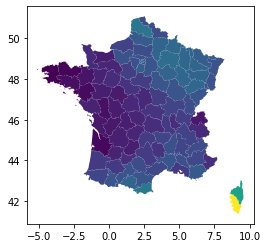

In [40]:
gdf.plot(column="averaged_values_y")

In [23]:
cc = pd.merge(
    df_dv_a.groupby("department_id").agg({"value": "mean"}).reset_index(), 
    df_dv_b.groupby("department_id").agg({"value": "mean"}).reset_index(), on=["department_id"]
)
cc["department_id"] = cc["department_id"].astype(str).str.zfill(2)
cc.sort_values("department_id")\
    .to_csv(f"data_regressions/test.csv", index=False)